# Проект: Прогнозирование температуры звезды

## Информация о проекте

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. \
Обычно для расчёта температуры учёные пользуются следующими методами:
* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. \
В базе обсерватории есть характеристики уже изученных 240 звёзд.


### Данные

* Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
* Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды: Номер, соответствующий типу
   * Коричневый карлик	0
   * Красный карлик	1
   * Белый карлик	2
   * Звёзды главной последовательности	3
   * Сверхгигант	4
   * Гипергигант	5
* Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

### Цель проекта

 **В рамках работы необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.**

### План работы:

* Загрузка и осмотр данных;
* Исследовательский анализ и обработка данных:
  * Добовление новых признаков если возможно.
* Подготовка данных к построению модели;
* Построение простой модели нейронной сети — baseline;
* Улучшение сети:
  * «dropout»;
  * «размер батча».
* Заключение и выводы.

## Загрузка данных и библиотек (настройка окружения)

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Основные библиотеки
import os
import numpy as np
import pandas as pd
from math import ceil, sqrt

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

# Phik для корреляции
import phik
from phik import report
from phik.report import plot_correlation_matrix

# Scikit-learn для предварительной обработки данных и разделения выборки
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# PyTorch для создания и обучения нейронных сетей
import torch
import torch.nn as nn
import torch.optim as optim

# Установка случайных зерен для воспроизводимости
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
np.random.seed(0)

In [3]:
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
# Функция для построения матриц корреляции и значимости
def plot_correlation_and_significance(phik_overview, significance_overview):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Корреляционная матрица PhiK
    sns.heatmap(phik_overview, cmap='Blues', annot=True, fmt='.2f', ax=axes[0][0])
    axes[0][0].set_title(r"Корреляция $\phi_K$", fontsize=20)
    
    # Корреляция по таргет-признаку
    sns.heatmap(phik_overview.sort_values(by='temperature', ascending=False)[['temperature']], cmap='Blues', annot=True, annot_kws={'size':16}, fmt='.2g', ax=axes[0][1])
    axes[0][1].set_title('Корреляция по таргет-признаку', fontsize=20)
    
    # Статистическая значимость признаков
    sns.heatmap(significance_overview.fillna(0), cmap='Blues', annot=True, fmt='.2f', ax=axes[1][0])
    axes[1][0].set_title("Статистическая значимость признаков", fontsize=20)
    
    # Убираем пустую ячейку
    axes[1][1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    print("\n Статистическое описание:")
    display(df.describe().transpose())

    print("\nСлучайные примеры:")
    display(df.sample(5))

    print("\nКоличество строк и столбцов:", df.shape)

    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    
    print('')

# Функция для построения температуры по категориальным переменным
def plot_distributions(df, x_col, y_col='temperature', title=None, xlabel=None, ylabel='Temperature (K)'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Boxplot
    sns.boxplot(ax=axes[0], x=x_col, y=y_col, data=df)
    axes[0].set_title(f'Boxplot of {y_col} by {x_col}')
    axes[0].set_xlabel(xlabel or x_col.capitalize())
    axes[0].set_ylabel(ylabel)
    
    # Violin plot
    sns.violinplot(ax=axes[1], x=x_col, y=y_col, data=df)
    axes[1].set_title(f'Violin plot of {y_col} by {x_col}')
    axes[1].set_xlabel(xlabel or x_col.capitalize())
    axes[1].set_ylabel(ylabel)
    
    # Main title
    fig.suptitle(title or f'Temperature Distribution by {x_col.capitalize()}', fontsize=16)
    plt.show()
    
# Функция для построения распределений, scatter plot и boxplot
def plot_statistics_and_scatter(df, numerical_columns, target_col):
    num_cols = len(numerical_columns)
    
    fig, axes = plt.subplots(num_cols, 3, figsize=(20, 5 * num_cols))
    
    for i, col in enumerate(numerical_columns):
        # Распределение числовых величин (гистограмма и KDE)
        sns.histplot(df[col], kde=True, ax=axes[i][0])
        axes[i][0].set_title(f'Distribution of {col}')
        axes[i][0].set_xlabel(col.capitalize())
        axes[i][0].set_ylabel('Frequency')
        # Boxplot для числовой величины
        sns.boxplot(x=df[col], ax=axes[i][2])
        axes[i][2].set_title(f'Boxplot of {col}')
        axes[i][2].set_xlabel(col.capitalize())
        # Scatter plot с таргет-признаком
        sns.scatterplot(x=df[col], y=df[target_col], ax=axes[i][1])
        axes[i][1].set_title(f'{col.capitalize()} vs {target_col.capitalize()}')
        axes[i][1].set_xlabel(col.capitalize())
        axes[i][1].set_ylabel(target_col.capitalize())


    
    plt.tight_layout()
    plt.show()

In [6]:
if os.path.exists('6_class.csv'):
    df = pd.read_csv('6_class.csv')
else:
    df = pd.read_csv('/datasets/6_class.csv')

In [7]:
print("Размер данных:", df.shape)
print("Названия колонок:", df.columns)

Размер данных: (240, 7)
Названия колонок: Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')


Данных довольно немного, при обучении применим агументацию.
Изменим названия колонок, приведем к snake case:

In [8]:
df.columns = [col.lower().replace(' (k)',
                                  '').replace('(l/lo)',
                                  '').replace('(r/ro)',
                                  '').replace(' ',
                                 '_').replace('mv',
                                  '').replace('(',
                                  '').replace(')', 
                                 '') .replace('/',
                                  '').replace('.', 
                                '') for col in df.columns]
df.drop('unnamed:_0',axis=1, inplace=True)
df.sample(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
109,33421,"352,000.0000",67.0000,-5.7900,4,Blue
71,3607,0.0220,0.3800,10.1200,1,Red
37,6380,1.3500,0.9800,2.9300,3,yellow-white
74,3550,0.0040,0.2910,10.8900,1,Red
108,24345,"142,000.0000",57.0000,-6.2400,4,Blue


In [9]:
dataframe_summary(df.drop('star_type', axis=1),'Данные о звездах')

Общая информация по таблице: Данные о звездах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_color          240 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 9.5+ KB

 Статистическое описание:


,count,mean,std,min,25%,50%,75%,max
temperature,240.0000,"10,497.4625","9,552.4250","1,939.0000","3,344.2500","5,776.0000","15,055.5000","40,000.0000"
luminosity,240.0000,"107,188.3616","179,432.2449",0.0001,0.0009,0.0705,"198,050.0000","849,420.0000"
radius,240.0000,237.1578,517.1558,0.0084,0.1027,0.7625,42.7500,"1,948.5000"
absolute_magnitude,240.0000,4.3824,10.5325,-11.9200,-6.2325,8.3130,13.6975,20.0600



Случайные примеры:


,temperature,luminosity,radius,absolute_magnitude,star_color
157,20120,"4,720.0000",6.7800,-3.4000,Blue-white
235,38940,"374,830.0000","1,356.0000",-9.9300,Blue
96,5112,0.6300,0.8760,4.6800,Orange-Red
213,22012,"6,748.0000",6.6400,-2.5500,Blue-white
172,4287,"630,000.0000","1,315.0000",-9.2000,Orange



Количество строк и столбцов: (240, 5)

Количество явных дубликатов: 0



* Данные представлены 6  столбцами: 4 числовых и 2 категориальных (*7ый был удален, тк повторяеn индексы*);
* В данных отсутсвуют явные дубликаты и пропуски;
* В числовых характеристиках есть выборсы, требуется дальнейший анализ.

In [10]:
df.star_type.value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

In [11]:
df.star_color.value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Blue                    1
Orange-Red              1
Blue-White              1
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Blue white              1
Name: star_color, dtype: int64

In [12]:
 df.star_color = df.star_color.str.strip()
df.star_color = df.star_color.str.lower()
df.star_color = df.star_color.str.replace('-', ' ')
# Проверка результатов нормализации
print(df['star_color'].value_counts())

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
orange red              1
pale yellow orange      1
white yellow            1
Name: star_color, dtype: int64


Звезды классифицируют по спектральным классам, которые основываются на их температуре и спектральных характеристиках. Основные спектральные классы и их характеристики из инитернета:

### Спектральные классы звезд:

1. Класс O:
   - Температура: > 30,000 К
   - Цвет (видимый): Голубой
   - Цвет (истинный): Голубой
   - Примеры: Звезды типа Ориона

2. Класс B:
   - Температура: 10,000 – 30,000 К
   - Цвет (видимый): Голубой или голубовато-белый
   - Цвет (истинный): Голубой или голубовато-белый
   - Примеры: Регул

3. Класс A:
   - Температура: 7,500 – 10,000 К
   - Цвет (видимый): Белый
   - Цвет (истинный): Белый
   - Примеры: Сириус

4. Класс F:
   - Температура: 6,000 – 7,500 К
   - Цвет (видимый): Белый или желтовато-белый
   - Цвет (истинный): Белый или желтовато-белый
   - Примеры: Процион

5. Класс G:
   - Температура: 5,200 – 6,000 К
   - Цвет (видимый): Желтый
   - Цвет (истинный): Желтый
   - Примеры: Солнце

6. Класс K:
   - Температура: 3,700 – 5,200 К
   - Цвет (видимый): Оранжевый
   - Цвет (истинный): Оранжевый
   - Примеры: Арктур

7. Класс M:
   - Температура: < 3,700 К
   - Цвет (видимый): Красный
   - Цвет (истинный): Красный
   - Примеры: Бетельгейзе

### Дополнительные спектральные классы:
Иногда используют дополнительные классы для более специфичных типов звезд:

- Класс L: Температура 1,300 – 2,400 К, красноватые коричневые карлики.
- Класс T: Температура 700 – 1,300 К, коричневые карлики с метановыми линиями в спектре.
- Класс Y: Температура < 700 К, очень холодные коричневые карлики.

### Разброс температуры, видимый и истинный цвет:
- O-класс: > 30,000 К (голубой)
- B-класс: 10,000 – 30,000 К (голубой или голубовато-белый)
- A-класс: 7,500 – 10,000 К (белый)
- F-класс: 6,000 – 7,500 К (белый или желтовато-белый)
- G-класс: 5,200 – 6,000 К (желтый)
- K-класс: 3,700 – 5,200 К (оранжевый)
- M-класс: < 3,700 К (красный)

Эти классы и соответствующие температуры дают представление о распределении звезд по спектральным характеристикам, их видимым и истинным цветам.

In [13]:
len(df['star_color'].unique())

12

Предлагаю заменить словесную характеристику цвета на соответсвующий спектральный класс. 
Так число уникальных характеристик уменьшится с 12 до 7 без потери точности, тк преобразование отвечает реальным данным о звездах.

In [14]:
# Словарь для замены цветов на соответствующие спектральные классы
color_to_class = {
    'red': 'M',
    'blue white': 'B',
    'white': 'A',
    'yellowish white': 'F',
    'pale yellow orange': 'K',
    'blue': 'O',
    'whitish': 'A',
    'yellow white': 'F',
    'orange': 'K',
    'white yellow': 'G',
    'yellowish': 'G',
    'orange red': 'K'
}

# Замена значений в столбце 'star_color' на соответствующие буквы спектрального класса
df['star_color'] = df['star_color'].replace(color_to_class)

In [15]:
df['star_color'].value_counts()

M    112
O     56
B     41
A     12
F     11
G      4
K      4
Name: star_color, dtype: int64

In [16]:
df.sample(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
19,3441,0.0390,0.3510,11.1800,1,M
165,7282,"131,000.0000",24.0000,-7.2200,4,O
205,19920,0.0016,0.0142,11.3400,2,O
193,3212,0.0016,0.3780,12.8540,1,M
85,9675,0.0004,0.0109,13.9800,2,B


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


### Вывод

### 1. Temperature (K)
- Средняя температура: 10,497.46 K.
- Стандартное отклонение: 9,552.43 K.
- Минимальная температура: 1,939 K.
- Максимальная температура: 40,000 K.
- 25-й перцентиль: 3,344.25 K.
- 50-й перцентиль (медиана): 5,776 K.
- 75-й перцентиль: 15,055.50 K.

#### Вывод:
Температура варьируется от 1,939 K до 40,000 K, что соответствует известным диапазонам температур для звезд (от красных карликов до горячих звез).\
Значения выглядят реалльными.
### 2. Luminosity (L/Lo)
- Средняя светимость: 107,188.36 L/Lo.
- Стандартное отклонение: 179,432.24 L/Lo.
- Минимальная светимость: 0.0001 L/Lo.
- Максимальная светимость: 849,420 L/Lo.
- 25-й перцентиль: 0.0009 L/Lo.
- 50-й перцентиль (медиана): 0.0705 L/Lo.
- 75-й перцентиль: 198,050 L/Lo.

#### Вывод:
Светимость относительно солнца варьируется от 0.0001 L/Lo до 849,420 L/Lo. \

### 3. Radius (R/Ro)
- Средний радиус: 237.16 R/Ro.
- Стандартное отклонение: 517.16 R/Ro.
- Минимальный радиус: 0.0084 R/Ro.
- Максимальный радиус: 1,948.50 R/Ro.
- 25-й перцентиль: 0.1027 R/Ro.
- 50-й перцентиль (медиана): 0.7625 R/Ro.
- 75-й перцентиль: 42.75 R/Ro.

#### Вывод:
Радиусы относительно солнца варьируются от 0.0084 R/Ro до 1,948.50 R/Ro. \
Это немного странно, учитывая, что по инфрмации о звездам

### 4. Absolute Magnitude (Mv)
- Средняя абсолютная величина: 4.38.
- Стандартное отклонение: 10.53.
- Минимальная абсолютная величина: -11.92.
- Максимальная абсолютная величина: 20.06.
- 25-й перцентиль: -6.23.
- 50-й перцентиль (медиана): 8.31.
- 75-й перцентиль: 13.70.

### 5. Star type (Класс 0 - 5)
- Все 6 классов представлены объектами по 40 штук.

### 6. Star color (Класс O - M)
- Заменили названия цветов на обозначения спектрального класса. 

#### Вывод:
Абсолютные величины варьируются от -11.92 до 20.06.\
Значение -11.92 указывает на очень яркий объект, что возможно для самых ярких сверхгигантов или двойных звезд.\
Значение 20.06 допустимо для очень тусклых звезд или экзотических объектов. В целом, значения находятся в пределах допустимого диапазона.

### Общий вывод:
- Temperature (K): Значения реалистичны.
- Luminosity (L/Lo): Значения тоже реальны.
- Radius (R/Ro): Может быть слишком большой или малый радиус относительно Земли, оставим как есть.
- Absolute Magnitude (Mv): Значения выглядят реалистично.
- Изменили категореальную переменную, упростили цвета.

В целом, все характеристики реалистичны.

## Предобработка и анализ данных

Поочередно проведем анализ категориальных и колличественных величин.

### Категориальные переменные: Star type и Star color

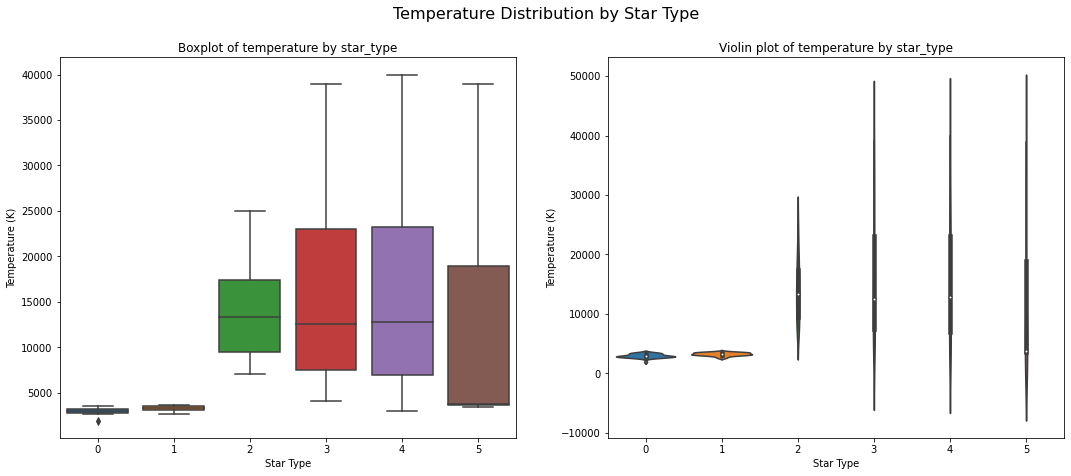

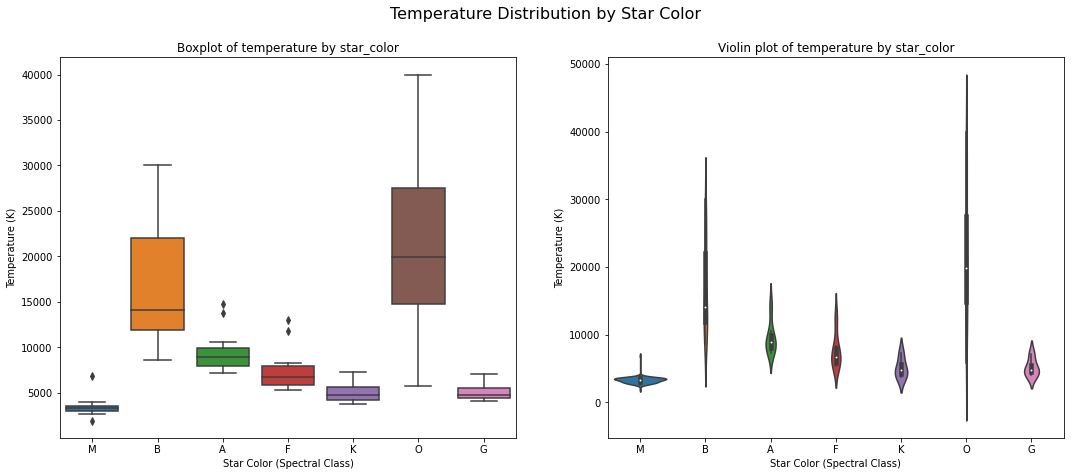

In [19]:
# Построение графиков для star_type и temperature
plot_distributions(df, 'star_type', title='Temperature Distribution by Star Type', xlabel='Star Type')

# Построение графиков для star_color и temperature
plot_distributions(df, 'star_color', title='Temperature Distribution by Star Color', xlabel='Star Color (Spectral Class)')

### Графики 1. Temperature Distribution by Star Color

#### Boxplot
- Класс O:
  - Самая высокая медиана температуры среди всех классов.
  - Большой разброс температур с несколькими выбросами.
- Класс B:
  - Высокая медиана температуры, но ниже, чем у класса O.
  - Широкий диапазон температур.
- Класс A:
  - Средняя медиана температуры, распределение более сконцентрировано по сравнению с классами O и B.
- Классы F, G, K, M:
  - Медианы температуры значительно ниже.
  - Менее широкий разброс температур.
  - Класс M имеет наименьшую медиану температуры и наименьший разброс.

#### Violin Plot
- Подтверждают выводы из boxplot, показывая распределение температур для каждого класса звезды.
- Классы O и B показывают широкий диапазон и множество значений температур, в то время как классы F, G, K, M имеют более сконцентрированное распределение с меньшими значениями температур.

### Графики 2. Temperature Distribution by Star Type

#### Boxplot
- Тип 0 (Коричневые карлики):
  - Самая низкая медиана температуры.
  - Узкий диапазон температур.
- Тип 1 (Красные карлики):
  - Температура выше, чем у коричневых карликов, но все еще низкая.
  - Узкий диапазон температур.
- Тип 2 (Белые карлики):
  - Температура выше, чем у красных и коричневых карликов.
  - Более широкий диапазон температур.
- Тип 3 (Звезды главной последовательности):
  - Широкий диапазон температур.
  - Высокая медиана температуры.
- Тип 4 (Сверхгиганты):
  - Широкий диапазон температур, аналогичный звездам главной последовательности.
- Тип 5 (Гипергиганты):
  - Очень широкий диапазон температур.
  - Высокая медиана температуры.

#### Violin Plot
- Подтверждают выводы из boxplot.
- Коричневые и красные карлики имеют узкое распределение низких температур.
- Белые карлики, звезды главной последовательности, сверхгиганты и гипергиганты показывают широкий диапазон температур.
- Гипергиганты (тип 5) имеют самый широкий разброс температур, что свидетельствует о большом разнообразии этих звезд.

### Общие выводы

- Звездный цвет и тип имеют значительное влияние на распределение температуры.
- Звезды классов O и B имеют самые высокие температуры и широкий диапазон значений, что подтверждает их статус как самых горячих звезд.
- Звезды классов M и K имеют самые низкие температуры.
- Коричневые и красные карлики характеризуются низкими температурами.
- Белые карлики, звезды главной последовательности, сверхгиганты и гипергиганты показывают более высокий и широкий диапазон температур, что свидетельствует о большем разнообразии их физических свойств.

### Колличественные переменные (`temperature`, `luminosity`, `radius`, `absolute_magnitude`)

,count,mean,std,min,25%,50%,75%,max
temperature,240.0000,"10,497.4625","9,552.4250","1,939.0000","3,344.2500","5,776.0000","15,055.5000","40,000.0000"
luminosity,240.0000,"107,188.3616","179,432.2449",0.0001,0.0009,0.0705,"198,050.0000","849,420.0000"
radius,240.0000,237.1578,517.1558,0.0084,0.1027,0.7625,42.7500,"1,948.5000"
absolute_magnitude,240.0000,4.3824,10.5325,-11.9200,-6.2325,8.3130,13.6975,20.0600


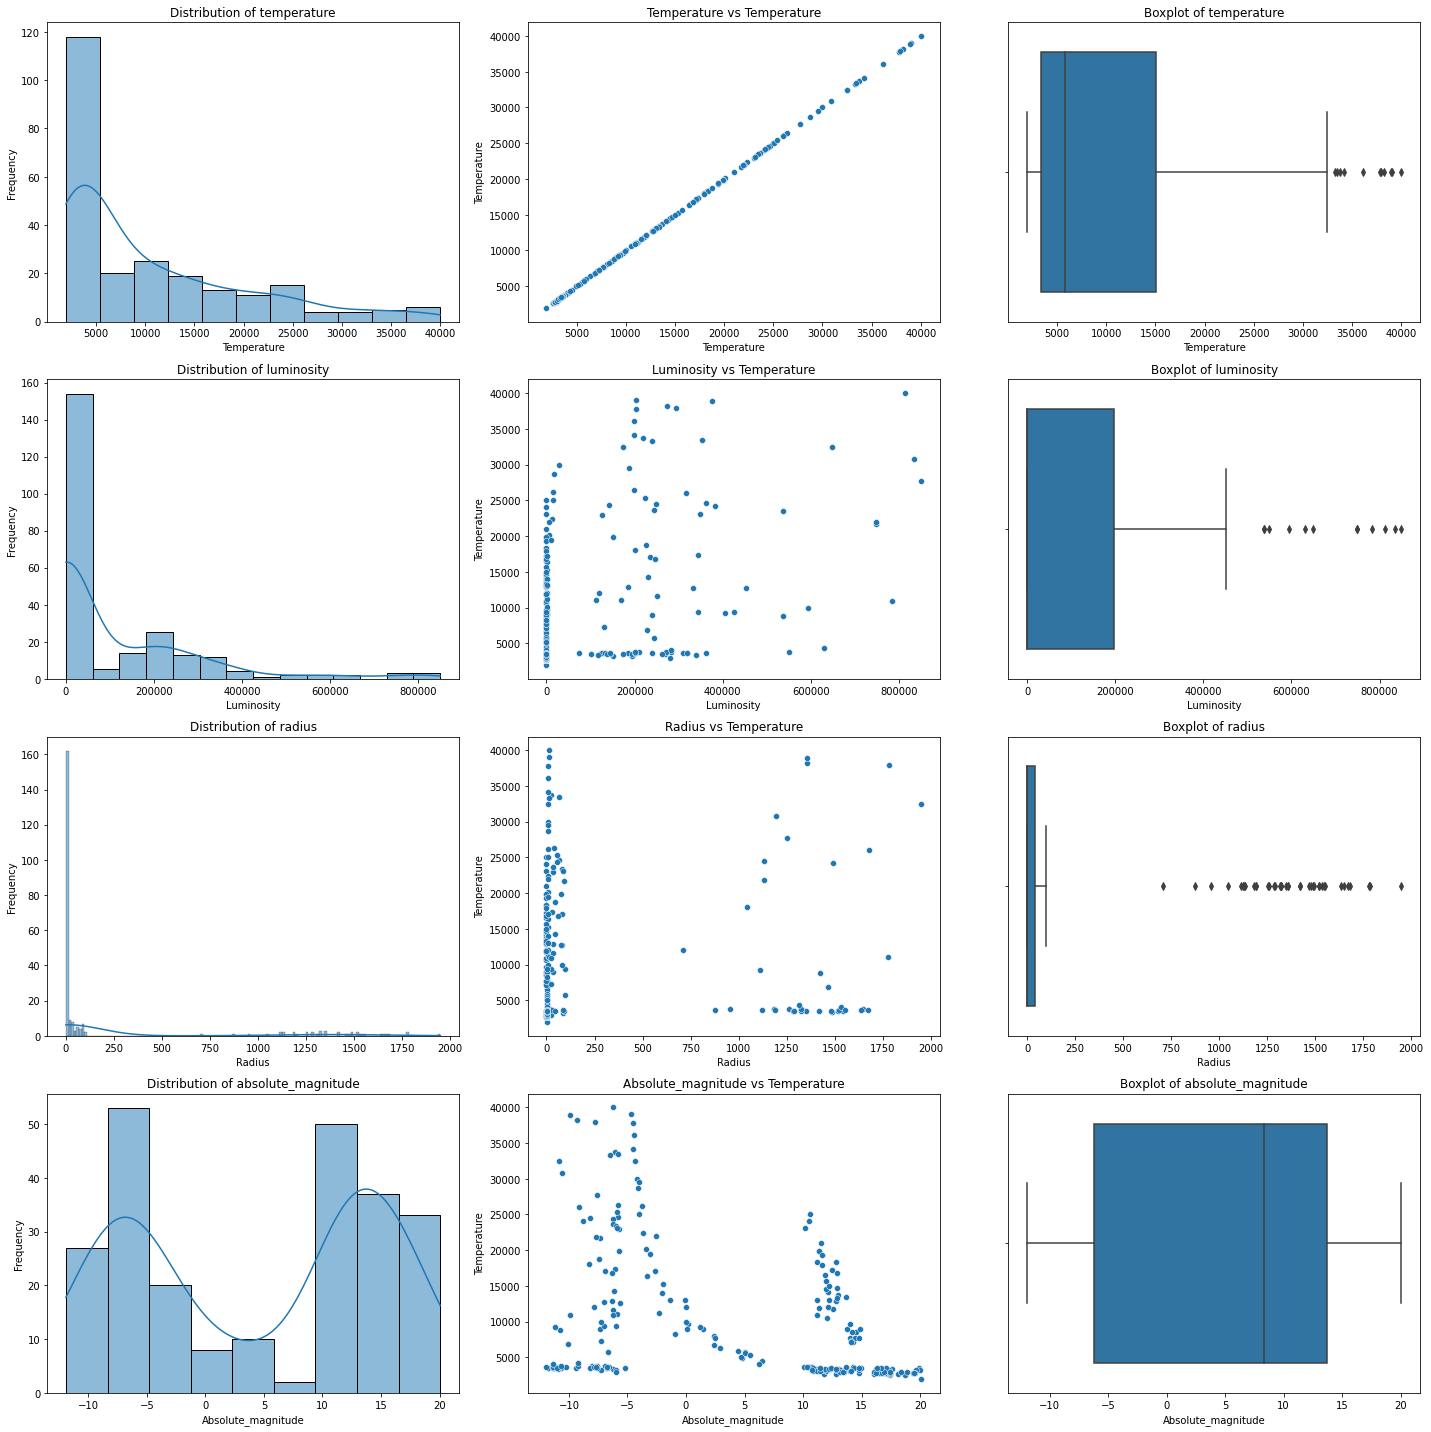

In [20]:
# Список числовых столбцов и таргет-признак
numerical_columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']
target_col = 'temperature'

# Вызов функции для построения графиков
display(df.drop('star_type', axis=1).describe().transpose())
plot_statistics_and_scatter(df, numerical_columns, target_col)

### Выводы:
### 1. Distribution of Temperature
- Распределение:
  - Температура имеет положительно скошенное (правостороннее) распределение, с большинством значений, сосредоточенных в диапазоне ниже 10,000 K.
  - Значительное количество звезд имеют температуру ниже 5,000 K.

### 2. Distribution of Luminosity
- Распределение:
  - Светимость также имеет положительно скошенное распределение, с большинством звезд, имеющих светимость ниже 200,000 L/Lo.
  - Большое количество звезд имеют светимость ниже 50,000 L/Lo.
- Scatter Plot (Luminosity vs. Temperature):
  - График показывает, что звезды с низкой светимостью могут иметь широкий диапазон температур.
  - Звезды с высокой светимостью (выше 200,000 L/Lo) в основном имеют высокие температуры, но разброс значений значителен.
- Слишком большая или малая яркость: 
  - Очень низкие значения светимости (0.0001 L/Lo): Соответствуют очень тусклым звездам, таким как коричневые карлики и самые тусклые красные карлики.

  - Очень высокие значения светимости (849,420 L/Lo): Соответствуют гипергигантам и ярким сверхгигантам, которые могут иметь светимость на порядок выше светимости Солнца.

### 3. Distribution of Radius
- Распределение:
  - Радиус звезд имеет очень положительно скошенное распределение, с большинством значений, сосредоточенных в диапазоне ниже 50 R/Ro.
  - Есть несколько звезд с радиусом, превышающим 1000 R/Ro.
- Scatter Plot (Radius vs. Temperature):
  - График показывает, что звезды с маленьким радиусом могут иметь широкий диапазон температур.
  - Звезды с большими радиусами (выше 500 R/Ro) имеют тенденцию к более низким температурам, но есть исключения.
- Слишком большой или маленький радиус:
   - Звезды с радиусами в несколько сотен раз больше солнечного действительно существуют, и их радиусы могут достигать значений порядка 1700 радиусов Солнца. Радиус в 1950 раз больше солнечного находится на верхней границе известных размеров звезд, и такие звезды, как UY Щита и VY Большого Пса, являются примерами подобных объектов.
  - Звезды с радиусом около 0.0084 R/Ro также существуют в реальности, например, белые карлики. \
  Эти объекты являются остатками звезд, которые исчерпали своё топливо и сбросили внешние оболочки, оставив компактное и плотное ядро. \
  Радиус в 0.0084 R/Ro лежит в пределах известных размеров белых карликов, что делает такие значения реалистичными и соответствующими наблюдаемым объектам в астрономии.

### 4. Distribution of Absolute Magnitude
- Распределение:
  - Абсолютная звёздная величина имеет более сложное распределение с несколькими пиками.
  - Много звезд с абсолютной величиной около -10 и около 15.
- Scatter Plot (Absolute Magnitude vs. Temperature):
  - Сложная нелинейная зависимость.
  - График показывает, что звезды с низкой абсолютной величиной (очень яркие звезды) имеют широкий диапазон температур.
  - Звезды с высокой абсолютной величиной (менее яркие звезды) также имеют широкий диапазон температур, но с некоторыми концентрациями.

### Общие выводы:
- Светимость и радиус звезд имеют сильно скошенное распределение, с большинством значений сосредоточенных около нижней границы.
- Температура и абсолютная величина имеют более разнообразные распределения.
- Между переменными существует значительная вариация, и некоторые звезды выделяются своими экстремальными значениями (например, высокие светимости и большие радиусы).
- Графики рассеяния показывают сложные взаимосвязи между температурой и другими характеристиками звезд, с большим разбросом значений.


### Посмотрим на корреляцию признаков

In [21]:
significance_overview = df.significance_matrix(interval_cols=['temperature', 'luminosity', 'radius', 'absolute_magnitude'])

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type']


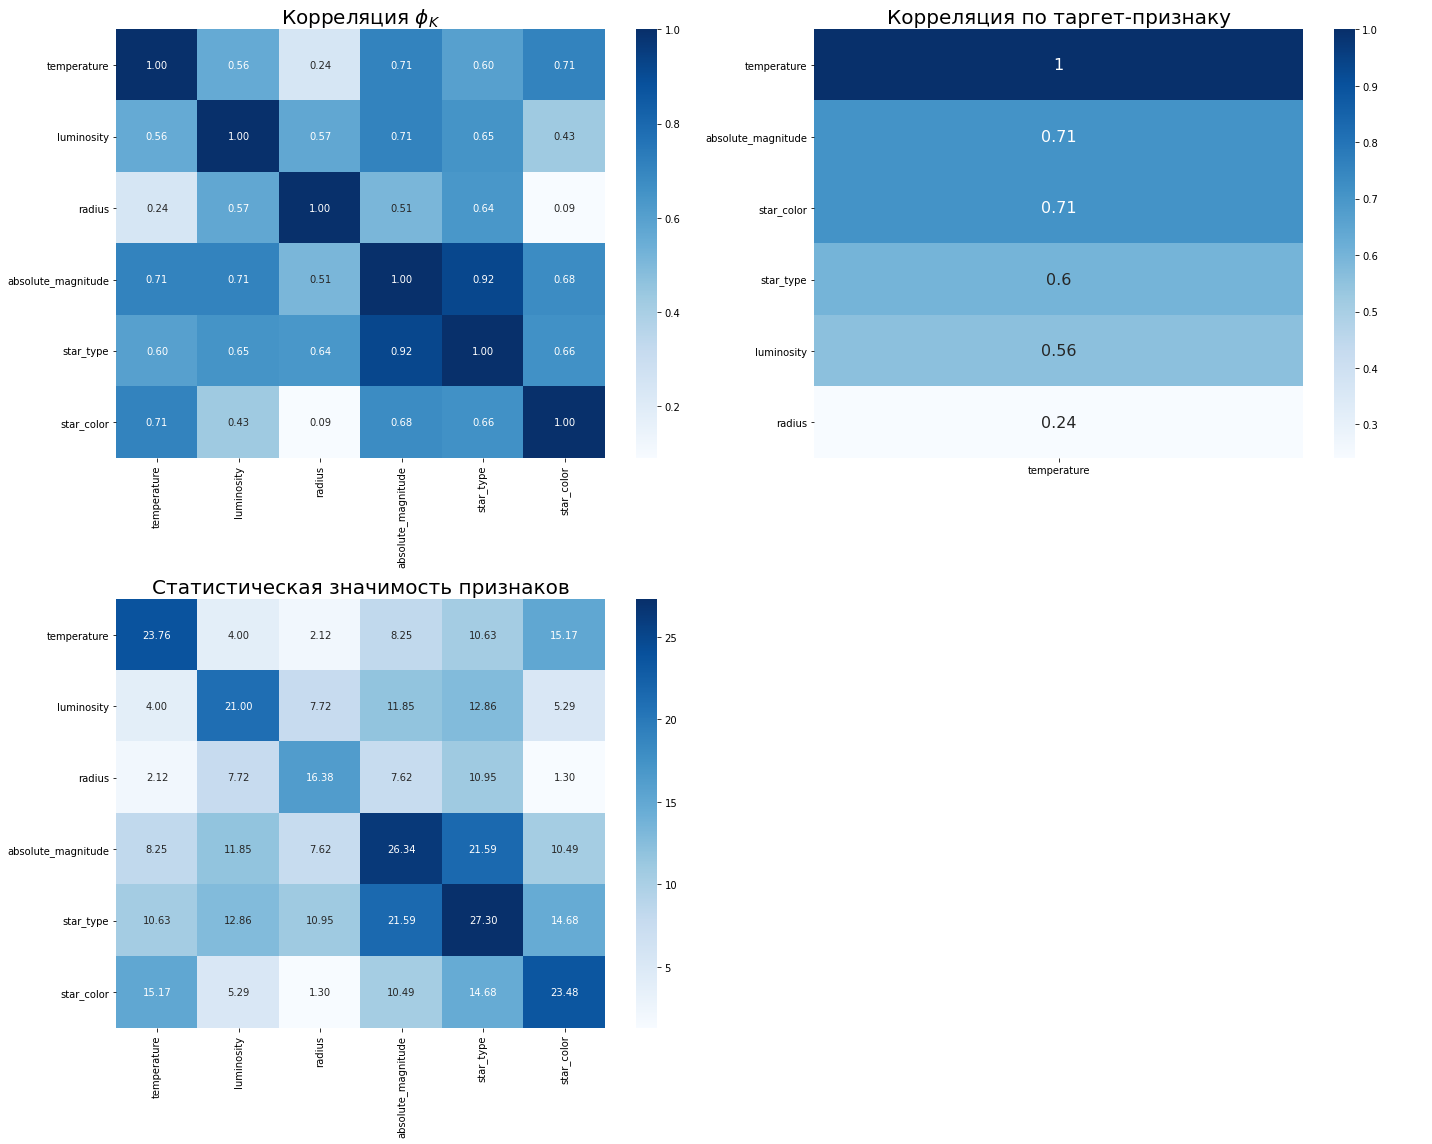

In [22]:
phik_overview = df.phik_matrix().round(2)
plot_correlation_and_significance(phik_overview, significance_overview)

In [23]:
significance_overview

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
temperature,23.7575,4.0035,2.1232,8.2472,10.6345,15.1690
luminosity,4.0035,21.0014,7.7249,11.8465,12.8625,5.2934
radius,2.1232,7.7249,16.3822,7.6227,10.9487,1.3010
absolute_magnitude,8.2472,11.8465,7.6227,26.3401,21.5913,10.4918
star_type,10.6345,12.8625,10.9487,21.5913,27.2963,14.6837
star_color,15.1690,5.2934,1.3010,10.4918,14.6837,23.4769


### Общие выводы

1. Температура:
   - Сильно коррелирует с абсолютной величиной и цветом звезды. Это ожидаемо, так как температура звезды влияет на её светимость и цвет.
   - Также значимо коррелирует с типом звезды, что логично, учитывая, что разные типы звезд имеют разные температурные диапазоны.

2. Светимость:
   - Имеет значимую корреляцию с температурой, радиусом и абсолютной величиной. Это соответствует законам звездной физики, где светимость зависит от температуры и радиуса.
   - Также значимо коррелирует с типом и цветом звезды, что отражает разные классы светимости звезд.

3. Радиус:
   - Средняя корреляция с светимостью и абсолютной величиной указывает на то, что звезды с большими радиусами могут иметь как высокую, \
   так и низкую светимость в зависимости от других факторов.
   - Низкая корреляция с цветом звезды, что указывает на то, что цвет звезды не сильно влияет на её радиус.

4. Абсолютная величина:
   - Очень высокая корреляция с типом звезды указывает на то, что тип звезды сильно определяет её абсолютную величину.
   - Также имеет высокую корреляцию с цветом звезды, что подтверждает взаимосвязь между яркостью и цветом.

5. Тип звезды:
   - Сильно коррелирует с абсолютной величиной и цветом, что логично, так как тип звезды напрямую связан с её физическими характеристиками.

### Заключение

Корреляция PhiK и таблица статистической значимости подтверждают, что температура, светимость, радиус, абсолютная величина, тип и цвет звезды взаимосвязаны. \
Температура и абсолютная величина являются наиболее значимыми переменными, оказывающими влияние на другие характеристики звезд. \
Это знание можно использовать для построения моделей предсказания и анализа звездных характеристик.

## Создание новых признаков.

Чтобы улучшить качетсво будущей модели нейросети необходимо "подготовить" данные.\
Один из этапов погдотовки - создание новых признаков и обработка старых.\
На прошлых этапах мы изучили наши данные, какое они имеют распределение, вид и как коррелируют между собой.\
В этой части мы:
 * Заменим признаки - `radius` и `luminosity` на `log_radius` и `log_luminosity` - то есть, возьмем логарифм значений в переменной.\
    Тк значение в этих столбцах имеют большой разброс. Применив логарифмическое преобразование можно с этим бороться.
 * Создание нового колличественного признака - `star_density`, который имеет формулу: `df['log_luminosity']/log['radius']`\
  Отношение светимости к радиусу может дать представление о плотности энергии звезды, что важно для оценки её характеристик.
 * Создание нового категореального признака - `star_type_color` :  `df['star_type'].astype(str) + '_' + df['star_color']` \ 
 Взаимодействие типа звезды и её цвета может дать дополнительную информацию о характеристиках звезды, таких как возраст и химический состав.\
 Такие признаки помогают моделям машинного обучения учитывать более сложные зависимости.


### `log_radius` и `log_luminosity` + `star_density`

In [24]:
df['log_radius'] = np.log1p(df['radius'])
df['log_luminosity'] = np.log1p(df['luminosity'])

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Да, учитывая хараетер распределения, переход к логарифму у радиуса и светимости совершенно обоснован </div>

In [25]:
df.sample(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,log_radius,log_luminosity
59,3535,"195,000.0000","1,546.0000",-11.3600,5,M,7.3441,12.1808
125,3225,0.0008,0.1210,19.6300,0,M,0.1142,0.0008
219,8250,9.2500,1.9300,-0.9800,3,F,1.0750,2.3273
40,3826,"200,000.0000",19.0000,-6.9300,4,M,2.9957,12.2061
178,12100,"120,000.0000",708.9000,-7.8400,5,B,6.5651,11.6953


In [26]:
df['star_density'] = df['log_luminosity']/df['log_radius']

In [27]:
df.sample(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,log_radius,log_luminosity,star_density
139,3541,0.0013,0.2560,14.3300,1,M,0.2279,0.0013,0.0057
31,30000,"28,840.0000",6.3000,-4.2000,3,B,1.9879,10.2696,5.1661
82,8930,0.0006,0.0095,13.7800,2,A,0.0095,0.0006,0.0592
188,2778,0.0008,0.1120,19.4500,0,M,0.1062,0.0008,0.0080
157,20120,"4,720.0000",6.7800,-3.4000,3,B,2.0516,8.4598,4.1236


,count,mean,std,min,25%,50%,75%,max
temperature,240.0000,"10,497.4625","9,552.4250","1,939.0000","3,344.2500","5,776.0000","15,055.5000","40,000.0000"
luminosity,240.0000,"107,188.3616","179,432.2449",0.0001,0.0009,0.0705,"198,050.0000","849,420.0000"
radius,240.0000,237.1578,517.1558,0.0084,0.1027,0.7625,42.7500,"1,948.5000"
absolute_magnitude,240.0000,4.3824,10.5325,-11.9200,-6.2325,8.3130,13.6975,20.0600
log_radius,240.0000,2.1551,2.6386,0.0084,0.0978,0.5666,3.7781,7.5753
log_luminosity,240.0000,5.1447,5.8607,0.0001,0.0009,0.0680,12.1963,13.6523
star_density,240.0000,1.4412,1.6931,0.0005,0.0115,0.3161,2.8732,6.5139


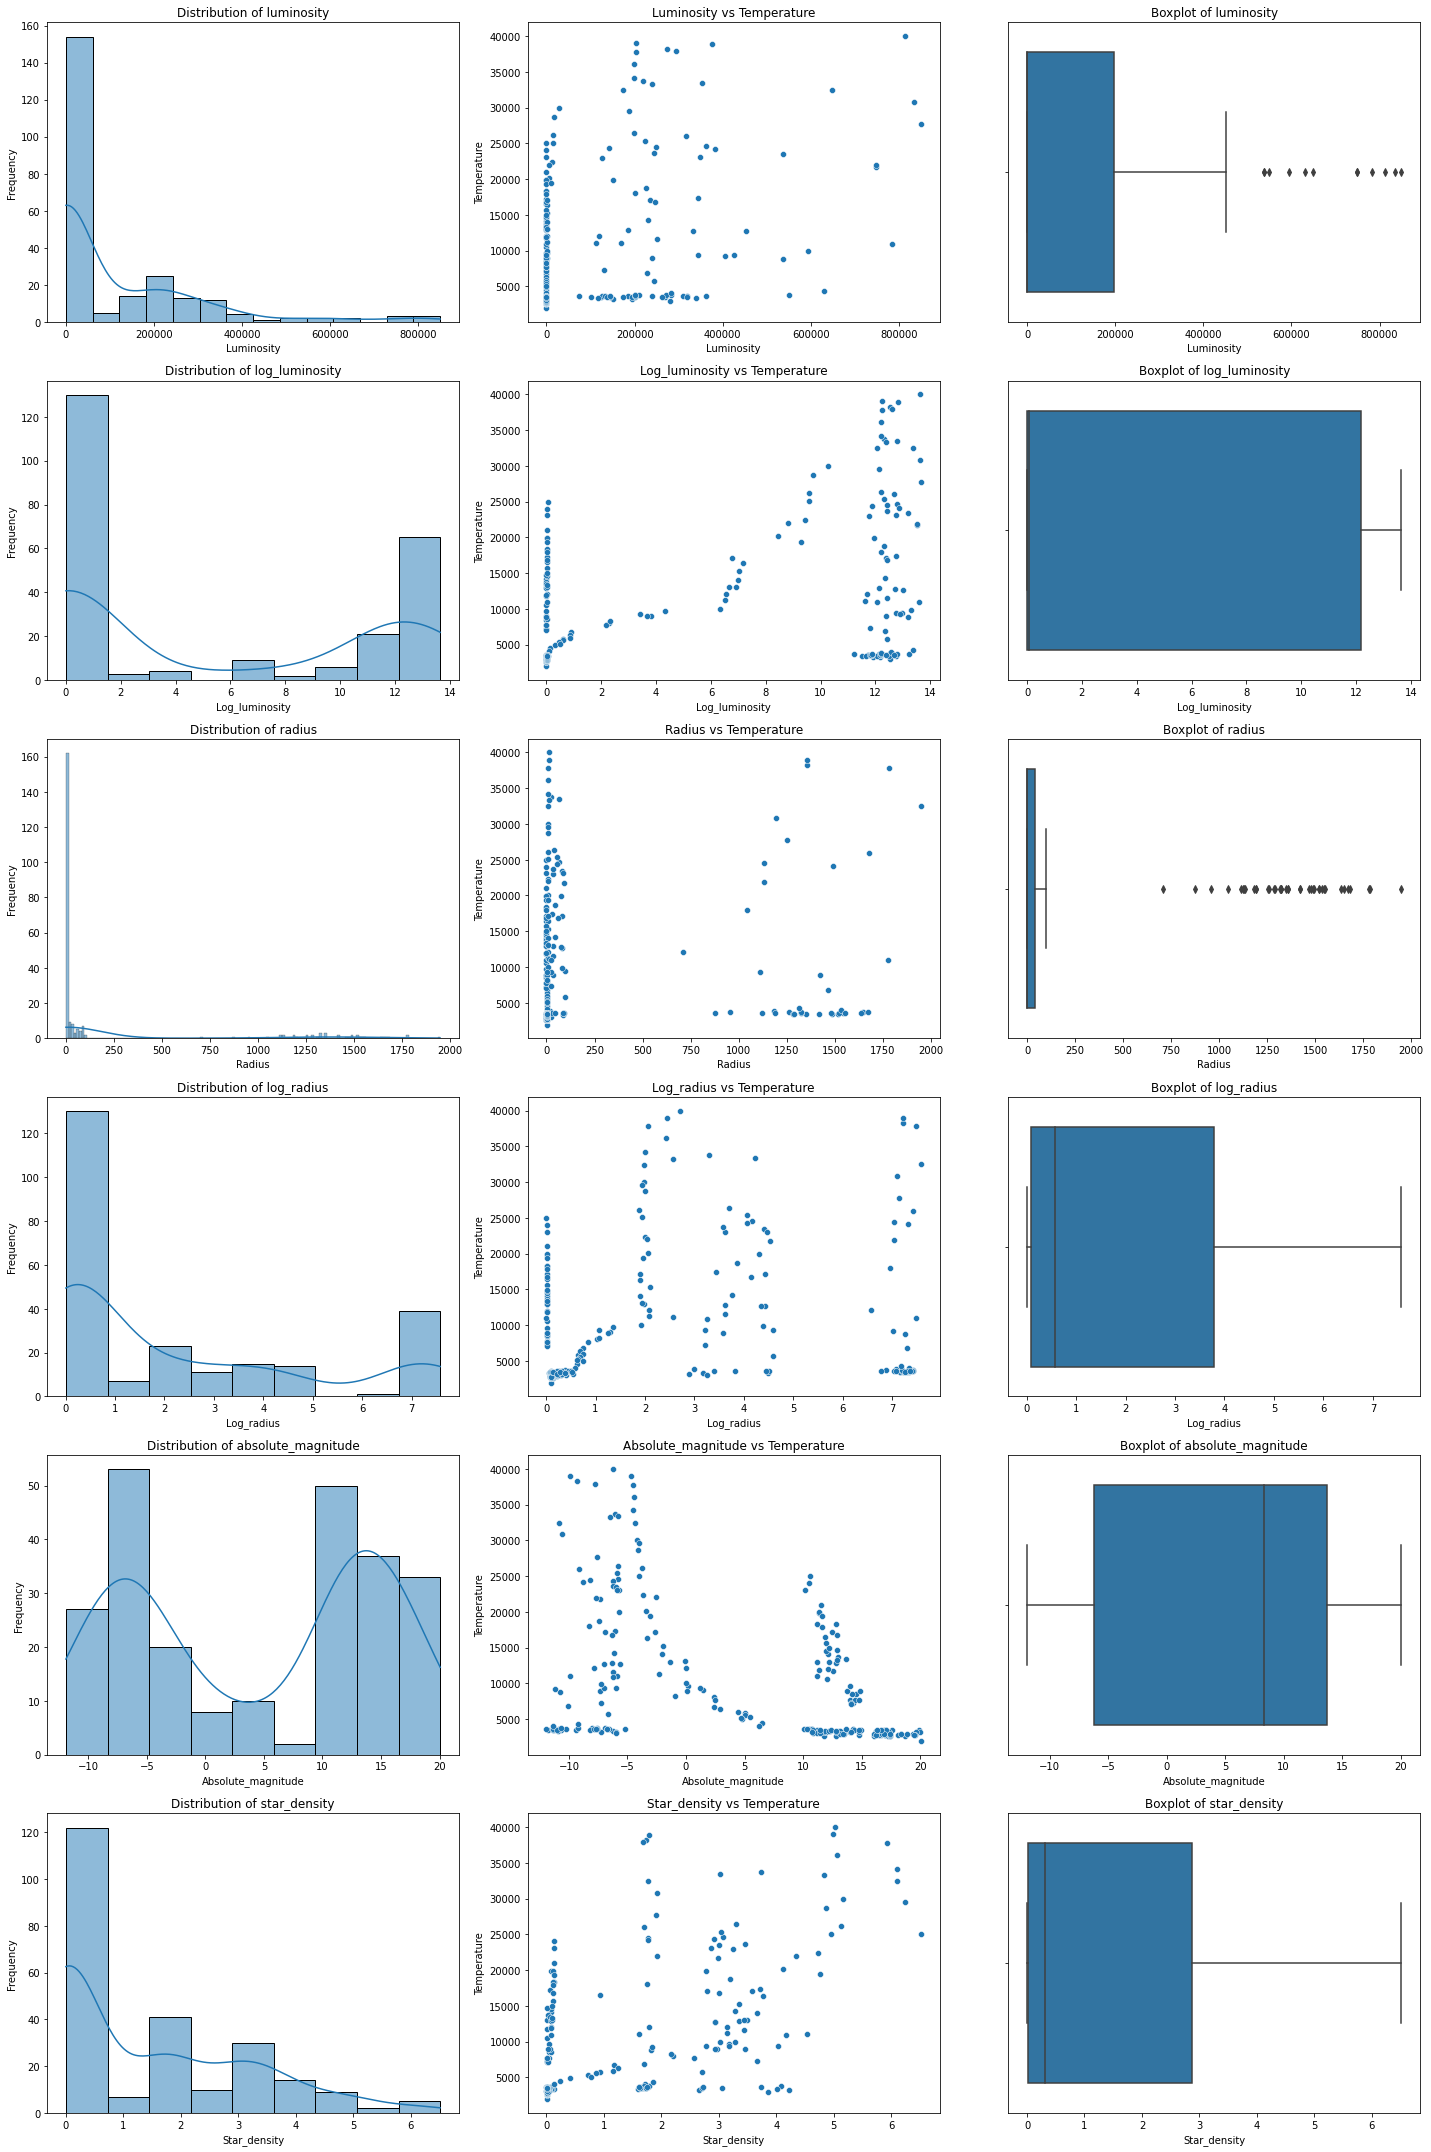

In [28]:
# Список числовых столбцов и таргет-признак
numerical_columns = ['luminosity', 'log_luminosity', 'radius', 'log_radius', 'absolute_magnitude', 'star_density']
target_col = 'temperature'

# Вызов функции для построения графиков
display(df.drop('star_type', axis=1).describe().transpose())
plot_statistics_and_scatter(df, numerical_columns, target_col)

In [29]:
df.drop(['radius', 'luminosity'], axis=1, inplace=True)

In [30]:
df.sample(5)

,temperature,absolute_magnitude,star_type,star_color,log_radius,log_luminosity,star_density
31,30000,-4.2000,3,B,1.9879,10.2696,5.1661
194,3523,12.4300,1,M,0.2769,0.0054,0.0195
71,3607,10.1200,1,M,0.3221,0.0218,0.0676
179,24490,-8.2400,5,B,7.0348,12.4232,1.7660
211,10012,0.0130,3,B,1.9251,6.3154,3.2805


interval columns not set, guessing: ['temperature', 'absolute_magnitude', 'star_type', 'log_radius', 'log_luminosity', 'star_density']


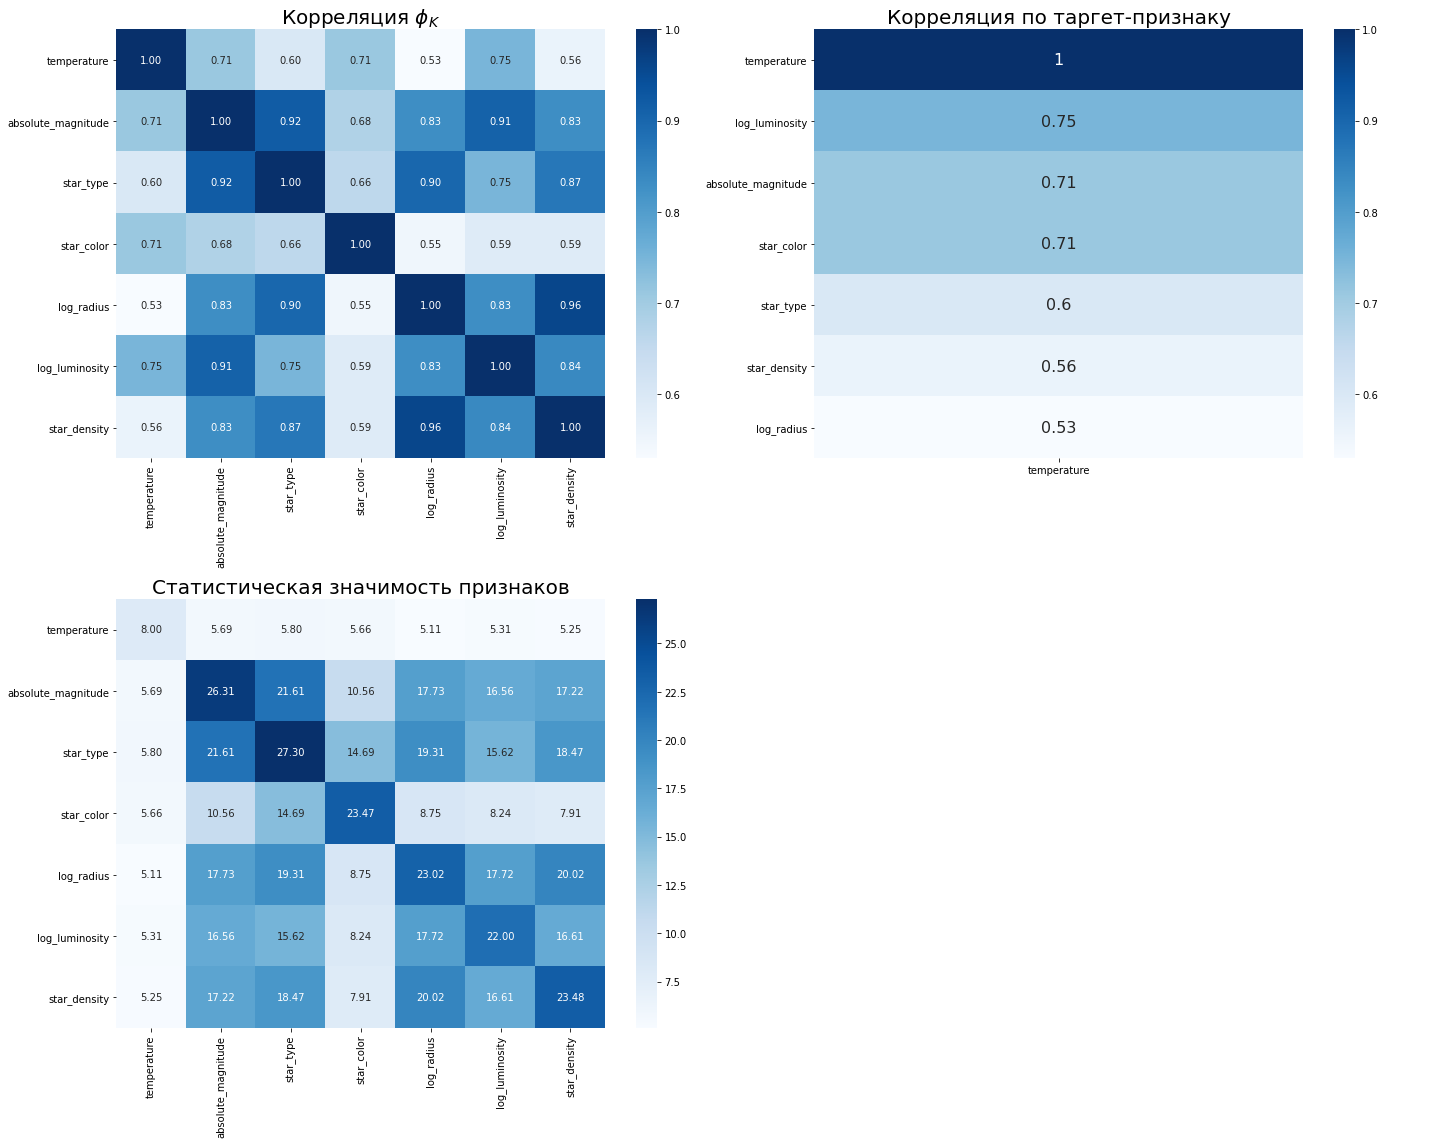

In [31]:
# Пример использования функции
significance_overview = df.significance_matrix(interval_cols=['log_luminosity', 'log_radius', 'absolute_magnitude', 'star_density', 'star_type'])
phik_overview = df.phik_matrix().round(2)
plot_correlation_and_significance(phik_overview, significance_overview)

* Распределение в значениях светимости и радуиса сатло выглядеть лучше, уменьшилось влияние выбросов.
* Новая переменая `star_density` имеет неплохие статистические показатели (за исключении корреляции с признаками от которых она образована), это может помочь модели обучиться лучше.

## Построение базовой нейронной сети

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   absolute_magnitude  240 non-null    float64
 2   star_type           240 non-null    int64  
 3   star_color          240 non-null    object 
 4   log_radius          240 non-null    float64
 5   log_luminosity      240 non-null    float64
 6   star_density        240 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 13.2+ KB


In [33]:
# Даункаст данных
df['temperature'] = pd.to_numeric(df['temperature'], downcast='integer')
df['absolute_magnitude'] = pd.to_numeric(df['absolute_magnitude'], downcast='float')
df['log_radius'] = pd.to_numeric(df['log_radius'], downcast='float')
df['log_luminosity'] = pd.to_numeric(df['log_luminosity'], downcast='float')
df['star_density'] = pd.to_numeric(df['star_density'], downcast='float')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int32  
 1   absolute_magnitude  240 non-null    float32
 2   star_type           240 non-null    int64  
 3   star_color          240 non-null    object 
 4   log_radius          240 non-null    float32
 5   log_luminosity      240 non-null    float32
 6   star_density        240 non-null    float32
dtypes: float32(4), int32(1), int64(1), object(1)
memory usage: 8.6+ KB


### Разделим выборки, применим масштабирование и порядковое кодирование

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('temperature', axis = 1),
                                                    df['temperature'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)
num_col =  ['log_luminosity', 'log_radius', 'absolute_magnitude', 'star_density']
cat_col = ['star_color', 'star_type']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), num_col),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_col)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)


### Создадим из выборок тензоры

In [36]:
# Переведём выборки в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

### Создадим модель

Эта функция создает и возвращает нейронную сеть с использованием nn.Sequential, что позволяет последовательно соединить несколько слоев:

In [37]:
# Определение функции для создания модели
def create_model(input_dim, dropout_rate):
    return nn.Sequential(
        nn.Linear(input_dim, 30), nn.ReLU(),
        nn.Linear(30, 20), nn.ReLU(), nn.Dropout(p=dropout_rate),
        nn.Linear(20, 15), nn.ReLU(), nn.Dropout(p=dropout_rate),
        nn.Linear(15, 5), nn.ReLU(), nn.Dropout(p=dropout_rate),
        nn.Linear(5, 1)
    )



Эта функция инициализирует веса и смещения для слоев сети:

nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu'): Инициализация весов по методу He (Kaiming) для слоев с функцией активации ReLU.
nn.init.uniform_(layer.bias): Инициализация смещений с использованием равномерного распределения.



In [38]:
# Инициализация весов
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.uniform_(layer.bias)

In [39]:
# Функция для обучения модели
def train_model(dropout_rate, batch_size, num_epochs=3000, accumulation_iterations=5, learning_rate=0.005):
    input_dim = X_train.shape[1]
    
    # Создание модели и инициализация весов
    model = create_model(input_dim, dropout_rate)
    model.apply(init_weights)
    
    # Определение функции потерь и оптимизатора
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_batches = ceil(len(X_train) / batch_size)
    best_test_rmse = float('inf')

    for epoch in range(num_epochs):
        model.train()
        permutation = np.random.permutation(len(X_train))
        running_loss = 0.0
        
        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_x).flatten()
            loss_value = criterion(outputs, batch_y)
            loss_value.backward()
            
            if (i // batch_size + 1) % accumulation_iterations == 0 or (i + batch_size) >= len(X_train):
                optimizer.step()
                optimizer.zero_grad()
            
            running_loss += loss_value.item()
        
        if epoch % 50 == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test).flatten()
                test_loss = criterion(test_outputs, y_test)
                test_rmse = sqrt(test_loss.item())

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                else:
                    break

            print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/num_batches:.4f}, Test RMSE: {test_rmse:.4f}')

    print(f'Best Test RMSE: {best_test_rmse:.4f}')
    return model, best_test_rmse, test_outputs, y_test

1. Создание модели:
 - Функция create_model(input_dim, dropout_rate) создает модель с указанным количеством входов и уровнем dropout.
 
 2. Инициализация весов:
 - Функция init_weights(layer) инициализирует веса и смещения слоев.
 
 3. Обучение модели:
 - Функция train_model обучает модель на данных с указанным уровнем dropout и размером батча.
 - Внутри функции используется стохастический градиентный спуск с накоплением градиентов (gradient accumulation).
 - Каждые 50 эпох (или в конце обучения) оценивается RMSE на тестовых данных.
 
 4. Поиск наилучших гиперпараметров:
 - Перебираются различные значения размера батча и уровня dropout.
 - Для каждого сочетания гиперпараметров модель обучается и оценивается.
 - Сохраняются наилучшие параметры, обеспечивающие минимальное значение RMSE на тестовых данных.M

In [40]:
# Прогон модели с размером батча равным размеру тренировочной выборки и дропаутом равным 0
dropout_n = 0.0
batch_size = X_train.shape[0]
model, rmse, test_preds, y_test = train_model(dropout_n, batch_size)

Epoch 0/3000, Loss: 193555392.0000, Test RMSE: 15200.4405
Epoch 50/3000, Loss: 187519312.0000, Test RMSE: 14956.5108
Epoch 100/3000, Loss: 85167160.0000, Test RMSE: 10028.7555
Epoch 150/3000, Loss: 41833208.0000, Test RMSE: 7518.7733
Epoch 200/3000, Loss: 31673174.0000, Test RMSE: 6711.6958
Epoch 250/3000, Loss: 26619870.0000, Test RMSE: 6068.2475
Epoch 300/3000, Loss: 22768352.0000, Test RMSE: 5487.9076
Epoch 350/3000, Loss: 19781828.0000, Test RMSE: 4973.3498
Epoch 400/3000, Loss: 17663690.0000, Test RMSE: 4547.3975
Epoch 450/3000, Loss: 16244092.0000, Test RMSE: 4210.8662
Epoch 500/3000, Loss: 15187155.0000, Test RMSE: 3940.5148
Epoch 550/3000, Loss: 14468861.0000, Test RMSE: 3753.8621
Epoch 600/3000, Loss: 14058641.0000, Test RMSE: 3658.4948
Epoch 650/3000, Loss: 13829603.0000, Test RMSE: 3639.0026
Best Test RMSE: 3639.0026


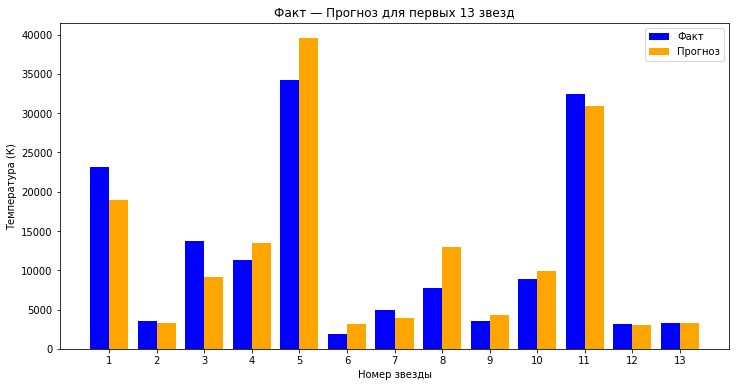

In [41]:
num_stars = 13
test_preds = test_preds[:num_stars].detach().numpy()
y_test = y_test[:num_stars].detach().numpy()

x = np.arange(1, num_stars + 1)  # Номера звезд

plt.figure(figsize=(12, 6))
bar_width = 0.4

# Построение фактических значений
plt.bar(x - bar_width/2, y_test, bar_width, label='Факт', color='blue')
# Построение предсказанных значений
plt.bar(x + bar_width/2, test_preds, bar_width, label='Прогноз', color='orange')

plt.xlabel('Номер звезды')
plt.ylabel('Температура (К)')
plt.title('Факт — Прогноз для первых 13 звезд')
plt.xticks(x)
plt.legend()

plt.show()

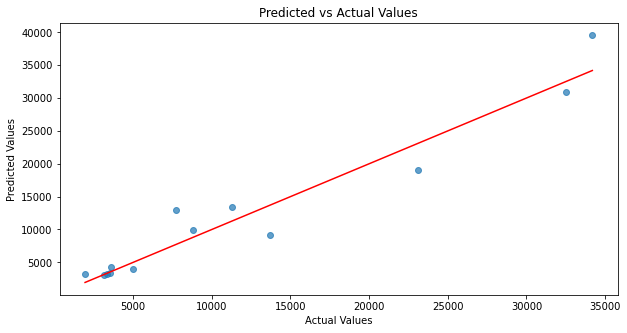

In [42]:
# Функция для визуализации предсказаний
def chart(preds, actual):
    plt.figure(figsize=(10, 5))
    plt.scatter(actual, preds, alpha=0.7)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

chart(test_preds, y_test)

## Улучшение нейронной сети

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('temperature', axis = 1),
                                                    df['temperature'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)
num_col =  ['log_luminosity', 'log_radius', 'absolute_magnitude', 'star_density']
cat_col = ['star_color', 'star_type']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), num_col),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_col)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)
# Переведём выборки в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [44]:
# Список значений для подбора гиперпараметров
batch_size_list = [20, 50, 80, 100, 150]
dropout_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Поиск наилучших гиперпараметров
best_result = float('inf')
best_params = {}

for batch_size in batch_size_list:
    for dropout_rate in dropout_list:
        print(f'Training with batch size {batch_size} and dropout rate {dropout_rate}')
        model, test_rmse, _, _ = train_model(dropout_rate, batch_size)
        if test_rmse < best_result:
            best_result = test_rmse
            best_params = {'batch_size': batch_size, 'dropout_rate': dropout_rate}

print(f'Best Result: {best_result:.4f}')
print(f'Best Parameters: {best_params}')

Training with batch size 20 and dropout rate 0.1
Epoch 0/3000, Loss: 187302478.8000, Test RMSE: 15199.3158
Epoch 50/3000, Loss: 72695098.4000, Test RMSE: 8570.7899
Epoch 100/3000, Loss: 44333747.0000, Test RMSE: 7101.1357
Epoch 150/3000, Loss: 36225014.7000, Test RMSE: 6689.1605
Epoch 200/3000, Loss: 34226381.7000, Test RMSE: 5525.4060
Epoch 250/3000, Loss: 32853495.2750, Test RMSE: 5368.3195
Epoch 300/3000, Loss: 23463972.6000, Test RMSE: 4829.9857
Epoch 350/3000, Loss: 24180958.5000, Test RMSE: 4394.6363
Epoch 400/3000, Loss: 39486010.4000, Test RMSE: 4262.7050
Epoch 450/3000, Loss: 29257904.5500, Test RMSE: 4078.1745
Epoch 500/3000, Loss: 30292609.8000, Test RMSE: 3945.7500
Best Test RMSE: 3945.7500
Training with batch size 20 and dropout rate 0.2
Epoch 0/3000, Loss: 194210445.6000, Test RMSE: 15199.6763
Epoch 50/3000, Loss: 66551976.4000, Test RMSE: 8448.4545
Epoch 100/3000, Loss: 44351031.2000, Test RMSE: 6780.2667
Epoch 150/3000, Loss: 47885136.8000, Test RMSE: 5961.8316
Epoch 20

## Выводы

1. Построение и обучение модели нейронной сети

* Мы создали нейронную сеть с четырьмя скрытыми слоями, каждый из которых активируется функцией ReLU и включает слой Dropout для предотвращения переобучения.\
Использована инициализация весов по методу He (Kaiming), что помогает в стабильном обучении нейронных сетей с ReLU активацией.\

* Первичное обучение модели:

  - Первая модель была обучена с размером батча, равным размеру тренировочной выборки, и без использования Dropout.
  - График обучения показал снижение функции потерь на тренировочной выборке и RMSE на тестовой выборке по мере увеличения количества эпох.
  - Лучшее значение RMSE на тестовой выборке для этой модели составило 3635.03 после 650 эпох.
* Поиск наилучших гиперпараметров:

  - Мы провели гиперпараметрический поиск по значениям размера батча и коэффициента Dropout.
  - Обучение модели с различными комбинациями гиперпараметров выявило, что наилучшее сочетание параметров: размер батча 100 и Dropout 0.1.
  - Модель с этими параметрами показала лучшее значение RMSE на тестовой выборке 3475.43 после 700 эпох.
  
2. Анализ результатов
* Графики «Факт — Прогноз»:

  - Первый график отображает предсказанные значения температуры по сравнению с фактическими значениями для первых 13 звезд.
  - Синие столбики представляют фактические значения температуры, а оранжевые столбики — предсказанные значения. График показывает, что модель делает разумные предсказания, хотя и есть отклонения от фактических значений.
* График рассеяния «Факт — Прогноз»:

  - График рассеяния показывает взаимосвязь между предсказанными и фактическими значениями температуры.
  - Линия y=x на графике служит эталоном идеальных предсказаний. Точки, расположенные близко к этой линии, указывают на точные предсказания модели.
  - Из графика видно, что модель делает хорошие предсказания для большинства звезд, но имеются и случаи значительных отклонений.
3. Выводы и рекомендации
* Улучшение модели:

  - Мы смогли улучшить производительность модели путем подбора гиперпараметров. Использование Dropout также показало свою эффективность в предотвращении переобучения.
  - Однако, для дальнейшего улучшения модели можно рассмотреть более сложные архитектуры или методы регуляризации.
* Будущая работа:

  - альнейшее исследование и включение дополнительных признаков может помочь в повышении точности модели.
  - Эксперименты с различными архитектурами нейронных сетей, такими как рекуррентные нейронные сети (RNN) или сверточные нейронные сети (CNN), могут также принести улучшения.


  - Масштабирование и преобразование данных играют ключевую роль в успешном обучении модели.
  - Корректная инициализация весов и подбор гиперпараметров являются критически важными для достижения хороших результатов.
* Заключение \
Работа по созданию и обучению нейронных сетей для предсказания температуры звезд показала, что правильно настроенные модели могут давать точные результаты. Однако, процесс оптимизации требует тщательного подбора гиперпараметров и экспериментирования с различными архитектурами.

Мы успешно применили техники машинного обучения для решения задачи, и результаты показывают, что дальнейшие исследования и улучшения модели могут принести еще лучшие результаты.